In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
plt.style.use('seaborn-whitegrid')
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.inspection import permutation_importance
from sklearn import preprocessing

In [2]:
df = pd.read_csv('OnlineNewsPopularity.csv')

In [3]:
df.columns = df.columns.str.replace(' ', '')

In [4]:
df

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.70,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.70,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.00,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.80,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.00,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,http://mashable.com/2014/12/27/samsung-app-aut...,8.0,11.0,346.0,0.529052,1.0,0.684783,9.0,7.0,1.0,...,0.100000,0.75,-0.260000,-0.500,-0.125000,0.100000,0.000000,0.400000,0.000000,1800
39640,http://mashable.com/2014/12/27/seth-rogen-jame...,8.0,12.0,328.0,0.696296,1.0,0.885057,9.0,7.0,3.0,...,0.136364,0.70,-0.211111,-0.400,-0.100000,0.300000,1.000000,0.200000,1.000000,1900
39641,http://mashable.com/2014/12/27/son-pays-off-mo...,8.0,10.0,442.0,0.516355,1.0,0.644128,24.0,1.0,12.0,...,0.136364,0.50,-0.356439,-0.800,-0.166667,0.454545,0.136364,0.045455,0.136364,1900
39642,http://mashable.com/2014/12/27/ukraine-blasts/,8.0,6.0,682.0,0.539493,1.0,0.692661,10.0,1.0,1.0,...,0.062500,0.50,-0.205246,-0.500,-0.012500,0.000000,0.000000,0.500000,0.000000,1100


In [5]:
def oneHot(data, col):
    data = pd.concat([data,pd.get_dummies(data[col])],axis=1)
    return data

In [6]:
def model_score(model):
    train_pred = model.predict(X_train)
    train_conf_matrix = metrics.confusion_matrix(y_train, train_pred)
    
    test_pred = model.predict(X_test)
    test_conf_matrix = metrics.confusion_matrix(y_test, test_pred)
    
    TN = train_conf_matrix[0][0]
    TP = train_conf_matrix[1][1]
    FP = train_conf_matrix[0][1]
    FN = train_conf_matrix[1][0]

    czulosc = TP/(TP+FN)
    specyficznosc = TN/(TN+FP)
    P = df['target'].sum()
    N = df.shape[0]-df['target'].sum()

    lift_P = czulosc/(P/(P+N))
    lift_N = specyficznosc/(N/(P+N))
    
    print("TRAIN")
    print("TP = " + str(TP))
    print("TN = " + str(TN))
    print("FP = " + str(FP))
    print("FN = " + str(FN))
    print("Czułość = " + str(czulosc))
    print("Specyficzność = " + str(specyficznosc))
    print("Losowy wybór czuł = " + str(P/(P+N)))
    print("Losowy wybór spec " + str(N/(P+N)))
    print("Przyrost (lift) czuł = " + str(lift_P))
    print("Przyrost (lift) spec = " + str(lift_N))
    
    TN = test_conf_matrix[0][0]
    TP = test_conf_matrix[1][1]
    FP = test_conf_matrix[0][1]
    FN = test_conf_matrix[1][0]

    czulosc = TP/(TP+FN)
    specyficznosc = TN/(TN+FP)
    P = df['target'].sum()
    N = df.shape[0]-df['target'].sum()

    lift_P = czulosc/(P/(P+N))
    lift_N = specyficznosc/(N/(P+N))
    
    print('TEST')
    print("TP = " + str(TP))
    print("TN = " + str(TN))
    print("FP = " + str(FP))
    print("FN = " + str(FN))
    print("Czułość = " + str(czulosc))
    print("Specyficzność = " + str(specyficznosc))
    print("Losowy wybór czuł = " + str(P/(P+N)))
    print("Losowy wybór spec " + str(N/(P+N)))
    print("Przyrost (lift) czuł = " + str(lift_P))
    print("Przyrost (lift) spec = " + str(lift_N))

In [7]:
def roc_curve(model, model_name):
    pred_prob_train = model.predict_proba(X_train)
    preds_train = pred_prob_train[:, 1]
    spec_train, czul_train, treshold_train = metrics.roc_curve(y_train, preds_train)
    roc_auc_train = metrics.auc(spec_train, czul_train)

    pred_prob_test = model.predict_proba(X_test)
    preds_test = pred_prob_test[:,1]
    spec_test, czul_test, treshold_test = metrics.roc_curve(y_test, preds_test)
    roc_auc_test = metrics.auc(spec_test, czul_test)

    print("AUC train = " + str(roc_auc_train))
    print("AUC test = " + str(roc_auc_test))
    
    plt.figure(figsize=(8,8))
    plt.plot(spec_test, czul_test, label='Test',color = (255/255, 59/255, 59/255))
    plt.plot(spec_train, czul_train, label='Train', color = (0/255, 60/255, 201/255))
    plt.plot([0, 1], [0, 1], '--', color = (41/255, 41/255, 41/255))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xticks(np.arange(0, 1.1, step=0.1))
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.xlabel('1 - Specyficzność',fontsize=13)
    plt.ylabel('Czułość',fontsize=13)
    plt.title(f'Krzywa ROC dla modelu {model_name}',fontsize=13)
    plt.legend(loc='lower right',fontsize = 13)
    plt.savefig(model_name+".png")
    plt.show()

In [8]:
### TARGET
df['target'] = np.where(df['shares']>=1400, 1, 0)

In [9]:
print(df[['shares','target']])
print("Liczba wiecej lub rownych 1400: ", df['target'].sum())
print("Liczba mniej niż 1400: ", df.shape[0]-df['target'].sum())

       shares  target
0         593       0
1         711       0
2        1500       1
3        1200       0
4         505       0
...       ...     ...
39639    1800       1
39640    1900       1
39641    1900       1
39642    1100       0
39643    1300       0

[39644 rows x 2 columns]
Liczba wiecej lub rownych 1400:  21154
Liczba mniej niż 1400:  18490


## diff max min positive polarity i diff max min negative polarity

In [10]:
df['diff_max_min_positive_polarity'] = df['max_positive_polarity'] - df['min_positive_polarity']

In [11]:
#df['diff_max_min_positive_polarity']

In [12]:
df['diff_max_min_negative_polarity'] = df['max_negative_polarity'] - df['min_negative_polarity']

In [13]:
#df['diff_max_min_negative_polarity']

## world_enter i tech_socmed i life_socmed i other

In [14]:
conditions = [
    (df['data_channel_is_lifestyle'] == 1),
    (df['data_channel_is_entertainment'] == 1),
    (df['data_channel_is_bus'] == 1),
    (df['data_channel_is_socmed'] == 1),
    (df['data_channel_is_tech'] == 1),
    (df['data_channel_is_world'] == 1),
    (df['data_channel_is_world']+df['data_channel_is_tech']+df['data_channel_is_socmed']+df['data_channel_is_bus']+df['data_channel_is_bus']+df['data_channel_is_entertainment']+df['data_channel_is_lifestyle']==0)]
choices = ["Lifestyle", "Entertainment", 'Bus','Socmed','Tech','World','Other']
df['data_channel'] = np.select(conditions, choices)
print(df['data_channel'])

0        Entertainment
1                  Bus
2                  Bus
3        Entertainment
4                 Tech
             ...      
39639             Tech
39640           Socmed
39641            Other
39642            World
39643    Entertainment
Name: data_channel, Length: 39644, dtype: object


In [15]:
df = oneHot(df, 'data_channel')

In [16]:
df.columns[65:72]

Index(['Bus', 'Entertainment', 'Lifestyle', 'Other', 'Socmed', 'Tech',
       'World'],
      dtype='object')

In [17]:
dc = df.columns.values[65:72]

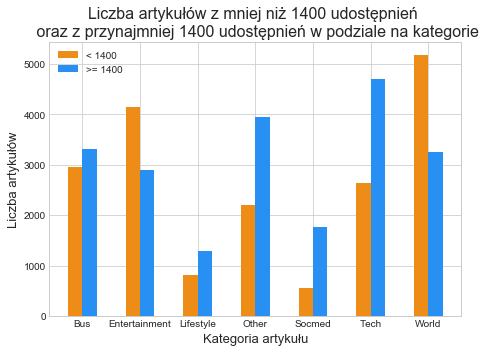

In [18]:
niepopularne = df[df['shares']<1400]
popularne = df[df['shares']>=1400]

ile_niepopularnych = niepopularne[dc].sum()
ile_popularnych = popularne[dc].sum()

fig = plt.figure(figsize = (7,5))
plt.title("Liczba artykułów z mniej niż 1400 udostępnień \n oraz z przynajmniej 1400 udostępnień w podziale na kategorie", fontsize = 16)
plt.bar(np.arange(len(dc)) - 0.125, ile_niepopularnych, width = 0.25, align = "center", color = (237/255, 141/255, 24/255), label = "< 1400")
plt.bar(np.arange(len(dc)) + 0.125, ile_popularnych, width = 0.25, align="center", color = (39/255, 144/255, 242/255), label = ">= 1400")

plt.xticks(np.arange(len(dc)), dc)
plt.ylabel("Liczba artykułów", fontsize = 13)
plt.xlabel("Kategoria artykułu", fontsize = 13)
    
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.savefig("img/dc_pop_unpop.png")
plt.show()

In [19]:
conditions = [
    ((df['data_channel'].str.lower() == 'world') | (df['data_channel'].str.lower() == 'entertainment')),
    ((df['data_channel'].str.lower() == 'lifestyle') | (df['data_channel'].str.lower() == 'socmed')),
    ((df['data_channel'].str.lower() == 'other') | (df['data_channel'].str.lower() == 'tech')),
    ((df['data_channel'].str.lower() is not 'world') & (df['data_channel'].str.lower() is not 'entertainment') & (df['data_channel'].str.lower() is not 'tech') & (df['data_channel'].str.lower() is not 'socmed') & (df['data_channel'].str.lower() is not 'lifestyle') & (df['data_channel'].str.lower() is not 'other'))]
choices = ["dc_is_world_enter","dc_is_lifestyle_socmed","dc_is_tech_other","dc_is_bus"]
df['dc_cat'] = np.select(conditions, choices)

In [20]:
df = oneHot(df, 'dc_cat')

In [45]:
Wd = df.columns.values[31:38]
Wd

array(['weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday',
       'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday',
       'weekday_is_sunday'], dtype=object)

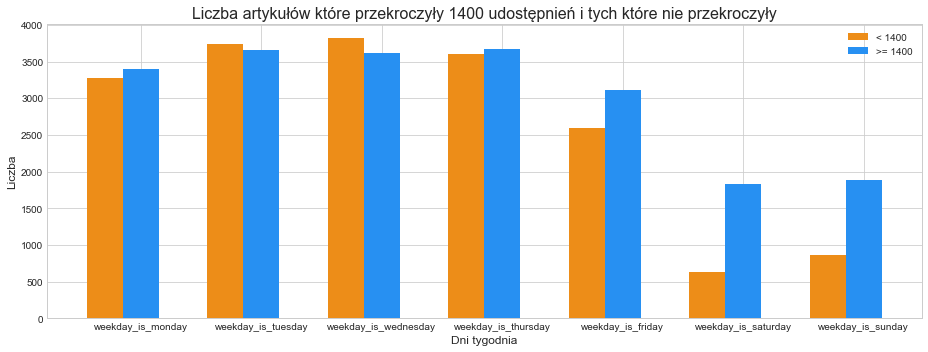

In [51]:
Unpop=df[df['shares']<1400]
Pop=df[df['shares']>=1400]
Unpop_day = Unpop[Wd].sum().values
Pop_day = Pop[Wd].sum().values

fig = plt.figure(figsize = (13,5))
plt.title("Liczba artykułów które przekroczyły 1400 udostępnień i tych które nie przekroczyły", fontsize = 16)
plt.bar(np.arange(len(Wd)) - 0.3, Unpop_day, width = 0.3, align = "center", color = (237/255, 141/255, 24/255), label = "< 1400")
plt.bar(np.arange(len(Wd)), Pop_day, width = 0.3, align="center", color = (39/255, 144/255, 242/255), label = ">= 1400")
plt.xticks(np.arange(len(Wd)), Wd)
plt.ylabel("Liczba", fontsize = 12)
plt.xlabel("Dni tygodnia", fontsize = 12)
    
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.savefig("img/dt_pop_unpop.png")
plt.show()

## n_art_in_day i n_art_in_day podzial na kategorie

In [21]:
df['n_art_in_day'] = df['shares'].groupby(df['timedelta']).transform('count')
#print(df['n_art_in_day'])

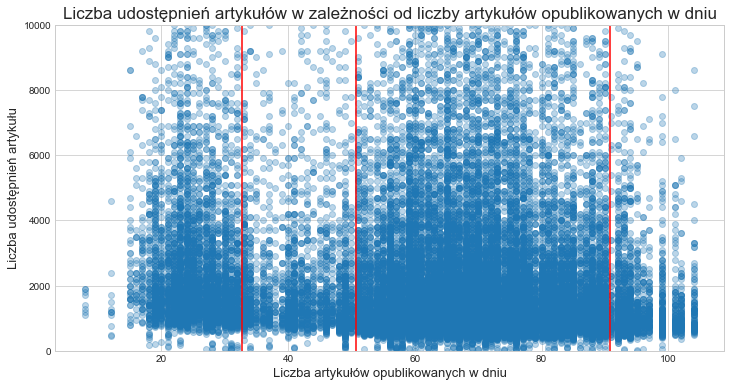

In [22]:
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(df['n_art_in_day'], df["shares"],alpha=0.3)

line = mlines.Line2D([0.28, 0.28], [1,0], color='red')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)

line = mlines.Line2D([0.45, 0.45], [1,0], color='red')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)

line = mlines.Line2D([0.83, 0.83], [1,0], color='red')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)

ax.set_title("Liczba udostępnień artykułów w zależności od liczby artykułów opublikowanych w dniu",fontsize=17)
ax.set_ylabel("Liczba udostępnień artykułu",fontsize=13)
ax.set_xlabel("Liczba artykułów opublikowanych w dniu",fontsize=13)
ax.set_ylim(0, 10000)
plt.savefig("img/shares_n_art_day.png")
plt.show()

In [23]:
conditions = [
    (df['n_art_in_day'] < 32),
    ((df['n_art_in_day'] >= 32) & (df['n_art_in_day'] < 51)),
    ((df['n_art_in_day'] >= 51) & (df['n_art_in_day'] < 90)),
    (df['n_art_in_day'] >= 90)]
choices = ["n_art_in_day_under_32","n_art_in_day_between_32_51","n_art_in_day_between_51_90","n_art_in_day_over_90"]
df['n_art_in_day_over_under'] = np.select(conditions, choices)

In [24]:
df = oneHot(df,'n_art_in_day_over_under')

## tokens_content_per_tokens_title

In [25]:
df['tok_content_per_tok_title'] = df['n_tokens_content'] /df['n_tokens_title']

In [26]:
df['tok_content_per_tok_title']

0         18.250000
1         28.333333
2         23.444444
3         59.000000
4         82.461538
            ...    
39639     31.454545
39640     27.333333
39641     44.200000
39642    113.666667
39643     15.700000
Name: tok_content_per_tok_title, Length: 39644, dtype: float64

## multimedia

In [27]:
over = 1
conditions = [
    (df['num_imgs']+df['num_videos'] > over),
    (df['num_imgs']+df['num_videos'] <= over)]
choices = [1,0]
df['mult_over_1'] = np.select(conditions, choices)

In [28]:
niepopularne = df[df['shares']<1400]
popularne = df[df['shares']>=1400]
ile_niepopularnych = niepopularne['mult_over_1'].sum()
ile_popularnych = popularne['mult_over_1'].sum()
print("Stosunek liczby artykułów popularnych do niepopularnych dla artykułów z ponad 1 aspektem multimedialnym: " + str(ile_popularnych/ile_niepopularnych))

ile_niepopularnych = df.shape[0]-niepopularne['mult_over_1'].sum()
ile_popularnych = df.shape[0]-popularne['mult_over_1'].sum()
print("Stosunek liczby artykułów popularnych do niepopularnych dla artykułów z maksymalnie 1 aspektem multimedialnym: " + str(ile_popularnych/ile_niepopularnych))

Stosunek liczby artykułów popularnych do niepopularnych dla artykułów z ponad 1 aspektem multimedialnym: 1.3335909040732972
Stosunek liczby artykułów popularnych do niepopularnych dla artykułów z maksymalnie 1 aspektem multimedialnym: 0.9011933954552885


## hrefs_ratio

In [29]:
df['hrefs_ratio'] = df['num_self_hrefs']/df['num_hrefs']
df = df.fillna(0,axis=1)

In [30]:
niepopularne = df[df['shares']<1400]
popularne = df[df['shares']>=1400]
sr_niepopularnych = niepopularne['hrefs_ratio'].mean()
sr_popularnych = popularne['hrefs_ratio'].mean()
print("Średnia dla popularnych: " + str(sr_popularnych))
print("Średnia dla niepopularnych: " + str(sr_niepopularnych))

Średnia dla popularnych: 0.39452788241302095
Średnia dla niepopularnych: 0.4274381358128969


In [31]:
df.columns

Index(['url', 'timedelta', 'n_tokens_title', 'n_tokens_content',
       'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
       'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
     

In [32]:
cols = [ 'timedelta','n_tokens_title','n_tokens_content','n_unique_tokens','n_non_stop_unique_tokens','num_hrefs','num_self_hrefs',
         'num_imgs','num_videos','average_token_length','num_keywords','kw_avg_min','kw_avg_max','kw_avg_avg','kw_min_min','kw_min_max','kw_min_avg','kw_max_min','kw_max_max','kw_max_avg',
         'self_reference_avg_sharess','LDA_00','LDA_01','LDA_02','LDA_03','LDA_04',
         'global_subjectivity','global_sentiment_polarity','global_rate_positive_words','global_rate_negative_words',
         'avg_positive_polarity','avg_negative_polarity','title_subjectivity','title_sentiment_polarity',
         'is_weekend','data_channel_is_tech','data_channel_is_bus','data_channel_is_lifestyle','data_channel_is_world','data_channel_is_entertainment','data_channel_is_socmed',
         'min_positive_polarity', 'max_positive_polarity', 'min_negative_polarity', 'max_negative_polarity',
         'diff_max_min_positive_polarity','diff_max_min_negative_polarity','tok_content_per_tok_title', 'n_art_in_day', 'hrefs_ratio',
         'mult_over_1',
         'dc_is_lifestyle_socmed','dc_is_world_enter','dc_is_tech_other',
         'n_art_in_day_under_32','n_art_in_day_between_32_51','n_art_in_day_between_51_90',
         'target']
len(cols)

58

In [33]:
data = df[cols]

In [34]:
data

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,n_art_in_day,hrefs_ratio,mult_over_1,dc_is_lifestyle_socmed,dc_is_world_enter,dc_is_tech_other,n_art_in_day_under_32,n_art_in_day_between_32_51,n_art_in_day_between_51_90,target
0,731.0,12.0,219.0,0.663594,0.815385,4.0,2.0,1.0,0.0,4.680365,...,79,0.500000,0,0,1,0,0,0,1,0
1,731.0,9.0,255.0,0.604743,0.791946,3.0,1.0,1.0,0.0,4.913725,...,79,0.333333,0,0,0,0,0,0,1,0
2,731.0,9.0,211.0,0.575130,0.663866,3.0,1.0,1.0,0.0,4.393365,...,79,0.333333,0,0,0,0,0,0,1,1
3,731.0,9.0,531.0,0.503788,0.665635,9.0,0.0,1.0,0.0,4.404896,...,79,0.000000,0,0,1,0,0,0,1,0
4,731.0,13.0,1072.0,0.415646,0.540890,19.0,19.0,20.0,0.0,4.682836,...,79,1.000000,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,8.0,11.0,346.0,0.529052,0.684783,9.0,7.0,1.0,1.0,4.523121,...,8,0.777778,1,0,0,1,1,0,0,1
39640,8.0,12.0,328.0,0.696296,0.885057,9.0,7.0,3.0,48.0,4.405488,...,8,0.777778,1,1,0,0,1,0,0,1
39641,8.0,10.0,442.0,0.516355,0.644128,24.0,1.0,12.0,1.0,5.076923,...,8,0.041667,1,0,0,1,1,0,0,1
39642,8.0,6.0,682.0,0.539493,0.692661,10.0,1.0,1.0,0.0,4.975073,...,8,0.100000,0,0,1,0,1,0,0,0


In [35]:
def Normalize(X):
    cols = X.columns
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(X.values)
    data_x = pd.DataFrame(x_scaled, columns = cols)
    return data_x

In [36]:
data1 = Normalize(data)

In [37]:
data1

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,n_art_in_day,hrefs_ratio,mult_over_1,dc_is_lifestyle_socmed,dc_is_world_enter,dc_is_tech_other,n_art_in_day_under_32,n_art_in_day_between_32_51,n_art_in_day_between_51_90,target
0,1.0,0.476190,0.025844,0.000947,0.001254,0.013158,0.017241,0.007812,0.000000,0.582024,...,0.739583,0.500000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.333333,0.030092,0.000863,0.001218,0.009868,0.008621,0.007812,0.000000,0.611043,...,0.739583,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.333333,0.024900,0.000820,0.001021,0.009868,0.008621,0.007812,0.000000,0.546334,...,0.739583,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,1.0,0.333333,0.062662,0.000719,0.001024,0.029605,0.000000,0.007812,0.000000,0.547768,...,0.739583,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.523810,0.126505,0.000593,0.000832,0.062500,0.163793,0.156250,0.000000,0.582331,...,0.739583,1.000000,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,0.0,0.428571,0.040831,0.000755,0.001054,0.029605,0.060345,0.007812,0.010989,0.562470,...,0.000000,0.777778,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
39640,0.0,0.476190,0.038707,0.000993,0.001362,0.029605,0.060345,0.023438,0.527473,0.547842,...,0.000000,0.777778,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
39641,0.0,0.380952,0.052160,0.000737,0.000991,0.078947,0.008621,0.093750,0.010989,0.631338,...,0.000000,0.041667,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
39642,0.0,0.190476,0.080481,0.000770,0.001066,0.032895,0.008621,0.007812,0.000000,0.618672,...,0.000000,0.100000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [38]:
data.columns

Index(['timedelta', 'n_tokens_title', 'n_tokens_content', 'n_unique_tokens',
       'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs',
       'num_videos', 'average_token_length', 'num_keywords', 'kw_avg_min',
       'kw_avg_max', 'kw_avg_avg', 'kw_min_min', 'kw_min_max', 'kw_min_avg',
       'kw_max_min', 'kw_max_max', 'kw_max_avg', 'self_reference_avg_sharess',
       'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'avg_positive_polarity',
       'avg_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'is_weekend', 'data_channel_is_tech',
       'data_channel_is_bus', 'data_channel_is_lifestyle',
       'data_channel_is_world', 'data_channel_is_entertainment',
       'data_channel_is_socmed', 'min_positive_polarity',
       'max_positive_polarity', 'min_negative_polarity',
       'max_negative_polarity', 'diff_ma

In [39]:
#ata.to_excel('data.xlsx',index=False)

In [40]:
#data1.to_excel('data_norm.xlsx',index=False)

In [41]:
X = data1.drop(columns=['target'])

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, data1['target'], random_state=1, test_size = 0.4)

In [43]:
X_train

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,tok_content_per_tok_title,n_art_in_day,hrefs_ratio,mult_over_1,dc_is_lifestyle_socmed,dc_is_world_enter,dc_is_tech_other,n_art_in_day_under_32,n_art_in_day_between_32_51,n_art_in_day_between_51_90
21710,0.408022,0.380952,0.054402,0.000737,0.000988,0.036184,0.008621,0.062500,0.000000,0.575375,...,0.048962,0.562500,0.090909,1.0,0.0,0.0,1.0,0.0,0.0,1.0
17567,0.526971,0.476190,0.118362,0.000594,0.000856,0.095395,0.017241,0.195312,0.010989,0.569947,...,0.088772,0.197917,0.068966,1.0,0.0,1.0,0.0,1.0,0.0,0.0
20611,0.437068,0.380952,0.044017,0.000737,0.000993,0.026316,0.068966,0.007812,0.000000,0.552427,...,0.039615,0.489583,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0
24358,0.340249,0.333333,0.064904,0.000659,0.000890,0.023026,0.043103,0.007812,0.000000,0.585596,...,0.064904,0.677083,0.714286,0.0,0.0,0.0,0.0,0.0,0.0,1.0
29240,0.228216,0.285714,0.120250,0.000691,0.001059,0.036184,0.008621,0.007812,0.000000,0.603100,...,0.135281,0.208333,0.090909,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7813,0.796680,0.285714,0.092164,0.000697,0.001002,0.046053,0.017241,0.007812,0.000000,0.605849,...,0.103685,0.500000,0.142857,0.0,1.0,0.0,0.0,0.0,0.0,1.0
32511,0.153527,0.428571,0.045551,0.000834,0.001115,0.052632,0.034483,0.015625,0.000000,0.554118,...,0.037269,0.770833,0.250000,1.0,0.0,0.0,0.0,0.0,0.0,1.0
5192,0.871369,0.476190,0.017583,0.000954,0.001210,0.003289,0.000000,0.000000,0.000000,0.561681,...,0.013187,0.593750,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0
12172,0.677732,0.428571,0.016639,0.000988,0.001359,0.006579,0.008621,0.000000,0.000000,0.591786,...,0.013614,0.635417,0.500000,0.0,0.0,0.0,1.0,0.0,0.0,1.0


## MLPClassifier

In [ ]:
parameters = {'batch_size': [32,64], 'hidden_layer_sizes': [(20,),(21,),(22,),(23,),(24,),(25,)], 'random_state': [1],'max_iter': [1000], 'verbose': ['False'],'solver':['adam'], 'activation':['logistic']}
mlpclf = GridSearchCV(MLPClassifier(), parameters, verbose=5, n_jobs=-1, scoring = 'accuracy', cv = 5)
mlpclf.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [73]:
print("Najlepszy wynik: %f dla%s" %(mlpclf.best_score_, mlpclf.best_params_))

Najlepszy wynik: 0.668713 dla{'activation': 'logistic', 'batch_size': 64, 'hidden_layer_sizes': (24,), 'max_iter': 1000, 'random_state': 1, 'solver': 'adam', 'verbose': 'False'}


In [75]:
means = mlpclf.cv_results_['mean_test_score']
params = mlpclf.cv_results_['params']
for mean, param in zip(means, params):
    print("Wynik:%.4f dla:%r" %(mean,param))

Wynik:0.6634 dla:{'activation': 'logistic', 'batch_size': 32, 'hidden_layer_sizes': (20,), 'max_iter': 1000, 'random_state': 1, 'solver': 'adam', 'verbose': 'False'}
Wynik:0.6670 dla:{'activation': 'logistic', 'batch_size': 32, 'hidden_layer_sizes': (21,), 'max_iter': 1000, 'random_state': 1, 'solver': 'adam', 'verbose': 'False'}
Wynik:0.6673 dla:{'activation': 'logistic', 'batch_size': 32, 'hidden_layer_sizes': (22,), 'max_iter': 1000, 'random_state': 1, 'solver': 'adam', 'verbose': 'False'}
Wynik:0.6652 dla:{'activation': 'logistic', 'batch_size': 32, 'hidden_layer_sizes': (23,), 'max_iter': 1000, 'random_state': 1, 'solver': 'adam', 'verbose': 'False'}
Wynik:0.6682 dla:{'activation': 'logistic', 'batch_size': 32, 'hidden_layer_sizes': (24,), 'max_iter': 1000, 'random_state': 1, 'solver': 'adam', 'verbose': 'False'}
Wynik:0.6646 dla:{'activation': 'logistic', 'batch_size': 32, 'hidden_layer_sizes': (25,), 'max_iter': 1000, 'random_state': 1, 'solver': 'adam', 'verbose': 'False'}
Wyni

In [96]:
#bez
clf = MLPClassifier(activation='relu', batch_size=64, hidden_layer_sizes=(14,),max_iter=1000, random_state=1,verbose=True,solver='adam')
#z
#clf = MLPClassifier(activation='logistic', batch_size=64, hidden_layer_sizes=(24,),max_iter=1000, random_state=1,verbose=True,solver='adam')

#clf = MLPClassifier(activation='logistic', batch_size=64, hidden_layer_sizes=(24,),max_iter=1000, random_state=1,verbose=True,solver='adam')
clf.fit(X_train, y_train)

Iteration 1, loss = 0.66134686
Iteration 2, loss = 0.64415272
Iteration 3, loss = 0.64028884
Iteration 4, loss = 0.63774813
Iteration 5, loss = 0.63572402
Iteration 6, loss = 0.63458536
Iteration 7, loss = 0.63297498
Iteration 8, loss = 0.63194816
Iteration 9, loss = 0.63106991
Iteration 10, loss = 0.63016280
Iteration 11, loss = 0.62922489
Iteration 12, loss = 0.62842618
Iteration 13, loss = 0.62772937
Iteration 14, loss = 0.62706622
Iteration 15, loss = 0.62624242
Iteration 16, loss = 0.62603918
Iteration 17, loss = 0.62520560
Iteration 18, loss = 0.62447958
Iteration 19, loss = 0.62408669
Iteration 20, loss = 0.62332846
Iteration 21, loss = 0.62279546
Iteration 22, loss = 0.62270257
Iteration 23, loss = 0.62218653
Iteration 24, loss = 0.62165348
Iteration 25, loss = 0.62136691
Iteration 26, loss = 0.62096544
Iteration 27, loss = 0.61990529
Iteration 28, loss = 0.61986850
Iteration 29, loss = 0.61970722
Iteration 30, loss = 0.61895910
Iteration 31, loss = 0.61852128
Iteration 32, los

MLPClassifier(activation='relu', alpha=0.0001, batch_size=64, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(14,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=True,
              warm_start=False)

In [97]:
print("Trafność Train = "+str(clf.score(X_train,y_train)))
print("Trafność Test = "+str(clf.score(X_test,y_test)))

Trafność Train = 0.6713613049693097
Trafność Test = 0.6580274940093328


In [76]:
model_score(clf)

TRAIN
TP = 9177
TN = 7216
FP = 3914
FN = 3479
Czułość = 0.7251106194690266
Specyficzność = 0.6483378256963163
Losowy wybór czuł = 0.5335990313792756
Losowy wybór spec 0.46640096862072444
Przyrost (lift) czuł = 1.3589054267859548
Przyrost (lift) spec = 1.3900867908006902
TEST
TP = 5952
TN = 4637
FP = 2723
FN = 2546
Czułość = 0.7004000941397976
Specyficzność = 0.6300271739130435
Losowy wybór czuł = 0.5335990313792756
Losowy wybór spec 0.46640096862072444
Przyrost (lift) czuł = 1.3125962622708773
Przyrost (lift) spec = 1.350827327344981


AUC train = 0.7374108058651746
AUC test = 0.7169500080581621


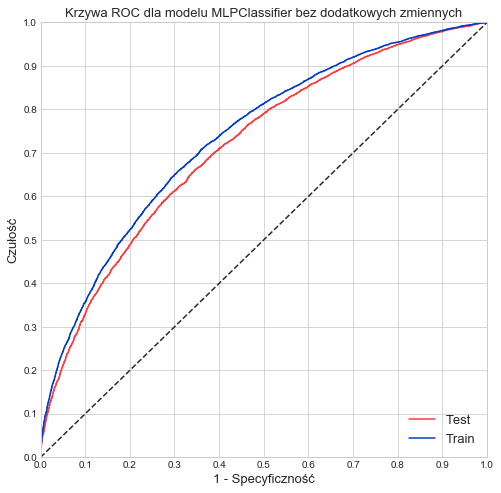

In [98]:
roc_curve(clf,'MLPClassifier bez dodatkowych zmiennych')

## DecisionTreeClassifier

In [49]:
parameters = {'criterion': ['entropy'], 'min_samples_split': [300,350,400,450,500], 'min_samples_leaf':[15,25,50,75,100],'max_depth':[9,10,11], 'max_leaf_nodes':[45,50,55,60,65]}
dtclf = GridSearchCV(DecisionTreeClassifier(), parameters, verbose=5, n_jobs=-1, scoring = 'accuracy', cv = 5)
dtclf.fit(X_train,y_train)

Fitting 5 folds for each of 375 candidates, totalling 1875 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 1875 out of 1875 | elapsed:  5.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': [9, 10, 11],
   

In [50]:
print("Najlepszy wynik: %f dla%s" %(dtclf.best_score_, dtclf.best_params_))

Najlepszy wynik: 0.653536 dla{'criterion': 'entropy', 'max_depth': 9, 'max_leaf_nodes': 65, 'min_samples_leaf': 50, 'min_samples_split': 500}


In [44]:
means = dtclf.cv_results_['mean_test_score']
params = dtclf.cv_results_['params']
#for mean, param in zip(means, params):
#    print("Wynik:%.4f dla:%r" %(mean,param))

In [99]:
#bez
dtc = DecisionTreeClassifier(criterion='entropy',min_samples_split = 200, min_samples_leaf = 100, max_depth=8, max_leaf_nodes=50)
#z
#dtc = DecisionTreeClassifier(criterion='entropy',min_samples_split = 500, min_samples_leaf = 50, max_depth=9, max_leaf_nodes=65)
#dtc = DecisionTreeClassifier(criterion='entropy',min_samples_split = 500, min_samples_leaf = 50, max_depth=9, max_leaf_nodes=65)

In [100]:
dtc.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=8, max_features=None, max_leaf_nodes=50,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=200,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [101]:
print("Trafność Train = "+str(dtc.score(X_train,y_train)))
print("Trafność Test = "+str(dtc.score(X_test,y_test)))

Trafność Train = 0.6612292945430085
Trafność Test = 0.6444066086517846


In [102]:
model_score(dtc)

TRAIN
TP = 9027
TN = 6701
FP = 4429
FN = 3629
Czułość = 0.7132585335018964
Specyficzność = 0.6020664869721474
Losowy wybór czuł = 0.5335990313792756
Losowy wybór spec 0.46640096862072444
Przyrost (lift) czuł = 1.3366938310555536
Przyrost (lift) spec = 1.2908774369672154
TEST
TP = 5930
TN = 4289
FP = 3071
FN = 2568
Czułość = 0.6978112497058131
Specyficzność = 0.5827445652173913
Losowy wybór czuł = 0.5335990313792756
Losowy wybór spec 0.46640096862072444
Przyrost (lift) czuł = 1.3077445959788812
Przyrost (lift) spec = 1.249449731935006


AUC train = 0.7158437080793245
AUC test = 0.6914915721857828


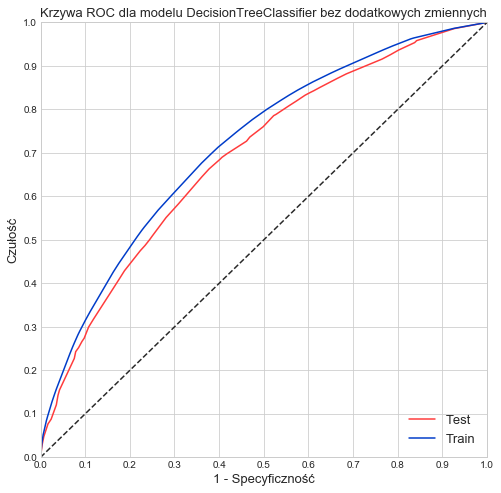

In [104]:
roc_curve(dtc,'DecisionTreeClassifier bez dodatkowych zmiennych')

In [64]:
dtc.feature_importances_

array([0.07391856, 0.        , 0.00895522, 0.        , 0.02342941,
       0.        , 0.        , 0.00536967, 0.        , 0.00772613,
       0.        , 0.01738659, 0.00449801, 0.25468218, 0.        ,
       0.        , 0.00815243, 0.        , 0.        , 0.05072605,
       0.13326546, 0.01696371, 0.        , 0.03001655, 0.        ,
       0.02164386, 0.        , 0.        , 0.00437657, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.12329152,
       0.02457791, 0.00409843, 0.        , 0.        , 0.11696952,
       0.04908936, 0.02086285, 0.        , 0.        , 0.        ])

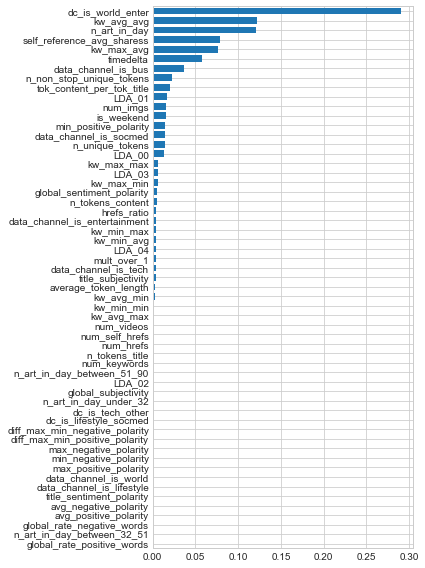

In [59]:
result = permutation_importance(dtc, X_train, y_train, n_repeats=1,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(dtc.feature_importances_)
tree_indices = np.arange(0, len(dtc.feature_importances_)) + 0.5

fig, (ax1) = plt.subplots(1, 1, figsize=(6, 8))
ax1.barh(tree_indices,
         dtc.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(data.columns[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(dtc.feature_importances_)))

fig.tight_layout()
plt.savefig('Ważność_DTClassifier.png')
plt.show()

# robić las bez i z

## RandomForestClassifier

In [50]:
parameters = {'n_estimators':[90,95,100], 'criterion':['entropy'], 'min_samples_split':[50,75,100], 'min_samples_leaf':[25,50,75], 'max_leaf_nodes':[100,105,110], 'max_depth':[9,10,11]}
rfclf = GridSearchCV(RandomForestClassifier(), parameters, verbose=5, n_jobs=-1, scoring = 'accuracy', cv = 5)
rfclf.fit(X_train,y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed: 26.4min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed: 35.2min
[Parallel(n_jobs=-1)]: Done 1215 out of 1215 | elapsed: 37.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [51]:
print("Najlepszy wynik: %f dla%s" %(rfclf.best_score_, rfclf.best_params_))

Najlepszy wynik: 0.670184 dla{'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 110, 'min_samples_leaf': 25, 'min_samples_split': 100, 'n_estimators': 90}


In [65]:
means = rfclf.cv_results_['mean_test_score']
params = rfclf.cv_results_['params']
# for mean, param in zip(means, params):
#     print("Wynik:%.4f dla:%r" %(mean,param))

In [106]:
#bez
#rf = RandomForestClassifier(criterion='entropy',max_leaf_nodes=70,min_samples_leaf=50,min_samples_split=200,n_estimators=90,max_depth=9)
#z
rf = RandomForestClassifier(criterion='entropy',max_leaf_nodes=110,min_samples_leaf=25,min_samples_split=100,n_estimators=90,max_depth=11)

In [107]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=11, max_features='auto',
                       max_leaf_nodes=120, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=90,
                       min_weight_fraction_leaf=0.0, n_estimators=950,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [108]:
print("Trafność Train = "+str(rf.score(X_train,y_train)))
print("Trafność Test = "+str(rf.score(X_test,y_test)))

Trafność Train = 0.6993609686370134
Trafność Test = 0.6703241266237862


In [109]:
model_score(rf)

TRAIN
TP = 9622
TN = 7013
FP = 4117
FN = 3034
Czułość = 0.7602718078381795
Specyficzność = 0.6300988319856244
Losowy wybór czuł = 0.5335990313792756
Losowy wybór spec 0.46640096862072444
Przyrost (lift) czuł = 1.4247998274528122
Przyrost (lift) spec = 1.3509809678333204
TEST
TP = 6205
TN = 4425
FP = 2935
FN = 2293
Czułość = 0.730171805130619
Specyficzność = 0.6012228260869565
Losowy wybór czuł = 0.5335990313792756
Losowy wybór spec 0.46640096862072444
Przyrost (lift) czuł = 1.3683904246288294
Przyrost (lift) spec = 1.2890685623251112


AUC train = 0.7760233330266485
AUC test = 0.7300855476224585


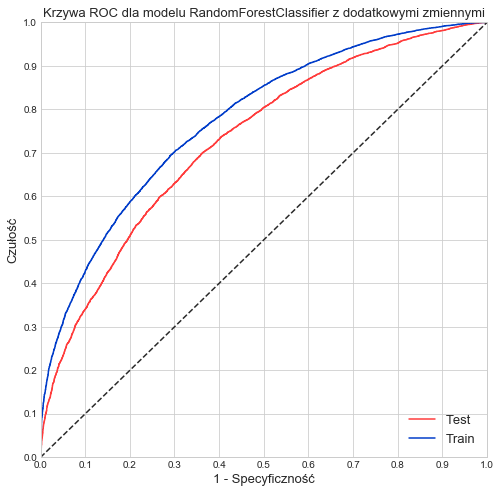

In [111]:
roc_curve(rf,'RandomForestClassifier z dodatkowymi zmiennymi')

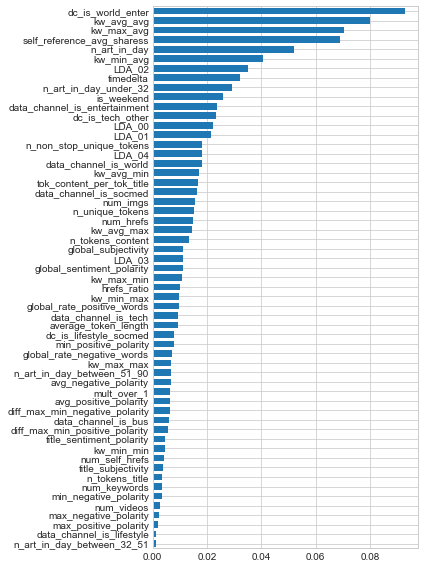

In [59]:
result = permutation_importance(rf, X_train, y_train, n_repeats=1,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(rf.feature_importances_)
tree_indices = np.arange(0, len(rf.feature_importances_)) + 0.5

fig, (ax1) = plt.subplots(1, 1, figsize=(6, 8))
ax1.barh(tree_indices,
         rf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(data.columns[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(rf.feature_importances_)))

fig.tight_layout()
plt.savefig('Ważność_RFClassifier.png')
plt.show()